In [9]:
import os
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, silhouette_samples
from sqlalchemy import create_engine
from IPython.display import display

In [10]:
config = {
    'host' : '195.88.211.140',
    'port' : 3306,
    'user' : 'datamini_admin2',
    'password' : 'Pr0gr3ssd4y',
    'database' : 'datamini_wpdb'
}

try:
    conn = mysql.connector.connect(**config)
    if conn.is_connected():
        print("Berhasil terhubung ke database")
        cursor = conn.cursor()
        cursor.execute("SELECT VERSION()")
        db_version = cursor.fetchone()
        print("Database version:", db_version)
except Exception as e:
    print("Error:", str(e))
finally:
    if 'conn' in locals() and conn.is_connected():
        cursor.close()
        conn.close()
        print("Koneksi ditutup")

Berhasil terhubung ke database
Database version: ('10.6.22-MariaDB',)
Koneksi ditutup


In [21]:
import pandas as pd
from sqlalchemy import create_engine

# 🔐 Koneksi DB
user     = 'datamini_admin2'
password = 'Pr0gr3ssd4y'
host     = '195.88.211.140'
port     = 3306
db       = 'datamini_wpdb'
conn_str = f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{db}"
engine   = create_engine(conn_str)

try:
    # 🚀 1. Ambil data customer
    print("📥 Mengambil wpkr_wc_customer_lookup...")
    query_cust = """
        SELECT
            customer_id,
            first_name,
            last_name,
            city
        FROM wpkr_wc_customer_lookup
    """
    df_customer_lookup = pd.read_sql(query_cust, engine)
    df_customer_lookup = df_customer_lookup.drop_duplicates(subset='customer_id')

    # 🚀 2. Ambil data agregat transaksi
    print("📥 Mengambil wpkr_wc_orders (agregat)...")
    query_agg = """
        SELECT
            customer_id,
            COUNT(id) AS jumlah_transaksi,
            CAST(SUM(total_amount) AS UNSIGNED) AS total_transaksi
        FROM wpkr_wc_orders
        GROUP BY customer_id
    """
    df_agg = pd.read_sql(query_agg, engine)

    # 🚀 3. Ambil order terakhir
    print("📥 Mengambil tanggal order terakhir...")
    query_date = """
        SELECT
            customer_id,
            MAX(date_created_gmt) AS order_date
        FROM wpkr_wc_orders
        GROUP BY customer_id
    """
    df_date = pd.read_sql(query_date, engine)

    # 🧠 4. Gabungkan semua data
    df_merge = (
        df_customer_lookup
            .merge(df_agg, on='customer_id', how='inner')
            .merge(df_date, on='customer_id', how='inner')
    )

    # 🧼 5. Bersihkan data
    df_merge['city'] = (
        df_merge['city']
        .str.strip()
        .str.replace(r'^(Kota|Kabupaten)\s+', '', regex=True)
        .str.title()
    )

    # 🚨 6. Cek dan buang missing values
    missing = df_merge.isnull().sum()
    print("\n🧹 Missing value check:\n", missing)

    df_merge = df_merge.dropna() 

    # 🧮 7. Hitung fitur baru
    df_merge['order_date'] = pd.to_datetime(df_merge['order_date'])

    # recency dalam hari
    df_merge['recency'] = (pd.to_datetime('today') - df_merge['order_date']).dt.days

    # rata-rata pemesanan per transaksi
    df_merge['rata-rata pemesanan (Rp)'] = (
        (df_merge['total_transaksi'] / df_merge['jumlah_transaksi'])
        .round(0)
        .astype(int)
    )

    # 📊 8. Tampilkan data
    print("\n📋 Tabel hasil akhir data:")
    display(df_merge.head(50))

except Exception as e:
    print("❌ Error saat koneksi atau query:", e)

finally:
    engine.dispose()
    print("✅ Koneksi database ditutup.")

📥 Mengambil wpkr_wc_customer_lookup...
📥 Mengambil wpkr_wc_orders (agregat)...
📥 Mengambil tanggal order terakhir...

🧹 Missing value check:
 customer_id         0
first_name          0
last_name           0
city                0
jumlah_transaksi    0
total_transaksi     0
order_date          0
dtype: int64

📋 Tabel hasil akhir data:


,customer_id,first_name,last_name,city,jumlah_transaksi,total_transaksi,order_date,recency,rata-rata pemesanan (Rp)
0,14,Fairlie,Preshaw,Pontianak,1,151900,2025-05-09 15:25:46,16,151900
1,15,Danyelle,Brideaux,Depok,1,729019,2025-05-10 04:02:09,15,729019
2,16,Ambrosius,Beall,Medan,1,329000,2025-05-09 15:34:35,16,329000
3,19,Marlene,Greally,Pontianak,1,650400,2025-05-10 04:13:21,15,650400
4,20,Roma,Langfat,Singkawang,1,499000,2025-05-09 16:31:12,16,499000
5,21,Dimitry,Fasset,Jakarta,1,20580,2025-05-09 15:37:30,16,20580
6,22,Liza,Gambell,Semarang,1,473000,2025-05-09 16:34:01,16,473000
7,23,Swen,Wittman,Surabaya,1,550000,2025-05-09 14:08:55,16,550000
8,24,Eberto,Nern,Pontianak,1,780000,2025-05-09 15:39:17,16,780000
9,25,Alexandros,Korneichik,Mempawah,1,870019,2025-05-10 04:15:20,15,870019


✅ Koneksi database ditutup.


In [22]:
# Menjalankan KMeans clustering berdasarkan lokasi, pola belanja, dan perilaku
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# One-hot encode 'city' agar bisa dipakai dalam clustering
city_encoded = pd.get_dummies(df_merge['city'], prefix='city')

# Gabungkan fitur numerik dan encoded city (lokasi)
features = pd.concat([
    df_merge[['jumlah_transaksi', 'total_transaksi', 'recency', 'rata-rata pemesanan (Rp)']],
    city_encoded
], axis=1)

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_merge['cluster'] = kmeans.fit_predict(X_scaled)

# Mendapatkan pusat cluster (centroid)
centroid_scaled = kmeans.cluster_centers_

# Mengembalikan Skala Centroid
centroids = scaler.inverse_transform(centroid_scaled)

# Distribusi lokasi per cluster
city_cluster = df_merge.groupby(['cluster', 'city']).size().unstack().fillna(0)
display(city_cluster)

# Profil masing-masing cluster (rata-rata tiap fitur)
cluster_profile = df_merge.groupby('cluster')[['jumlah_transaksi', 'total_transaksi', 'recency', 'rata-rata pemesanan (Rp)']].mean()
 
# Format tampilan hasil profiling
cluster_profile.style.format({
    'jumlah_transaksi': '{:.2f}',
    'total_transaksi': 'Rp {:,.0f}',
    'recency': '{:.0f} hari',
    'rata-rata pemesanan (Rp)': 'Rp {:,.0f}'
})

city,Balikpapan,Bandung,Banjarmasin,Bekasi,Denpasar,Depok,Gorontalo,Indragiri Hilir,Jakarta,Jakarta Barat,...,Palangkaraya,Palembang,Pontianak,Samarinda,Semarang,Singkawang,Sintang,Solo,Surabaya,Yogyakarta
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,4.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,...,3.0,1.0,42.0,1.0,1.0,3.0,1.0,1.0,1.0,4.0


,jumlah_transaksi,total_transaksi,recency,rata-rata pemesanan (Rp)
cluster,,,,
0,1.00,"Rp 120,145",15 hari,"Rp 120,145"
1,1.18,"Rp 517,643",16 hari,"Rp 401,160"


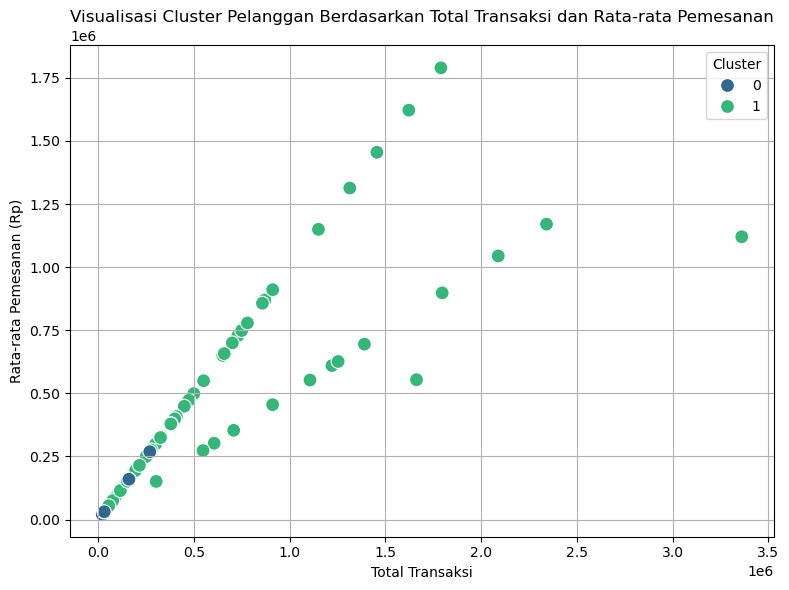

In [23]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_merge, 
    x='total_transaksi', 
    y='rata-rata pemesanan (Rp)', 
    hue='cluster', 
    palette='viridis', 
    s=100
)
plt.title("Visualisasi Cluster Pelanggan Berdasarkan Total Transaksi dan Rata-rata Pemesanan")
plt.xlabel("Total Transaksi")
plt.ylabel("Rata-rata Pemesanan (Rp)")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("assets/visualisasi1_scatter.webp", format='webp')
plt.show()

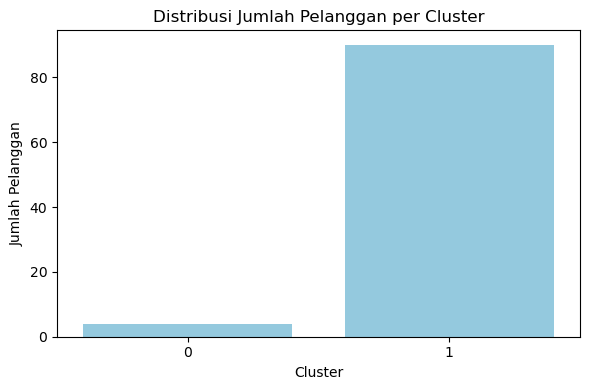

In [24]:
# Distribusi Jumlah Pelanggan per Cluster
# Hitung jumlah pelanggan per cluster
cluster_counts = df_merge['cluster'].value_counts().sort_index()

# Visualisasi
plt.figure(figsize=(6,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, color='skyblue')
plt.title('Distribusi Jumlah Pelanggan per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("assets/visualisasi2_bar_cluster_count.webp", format='webp')
plt.show()

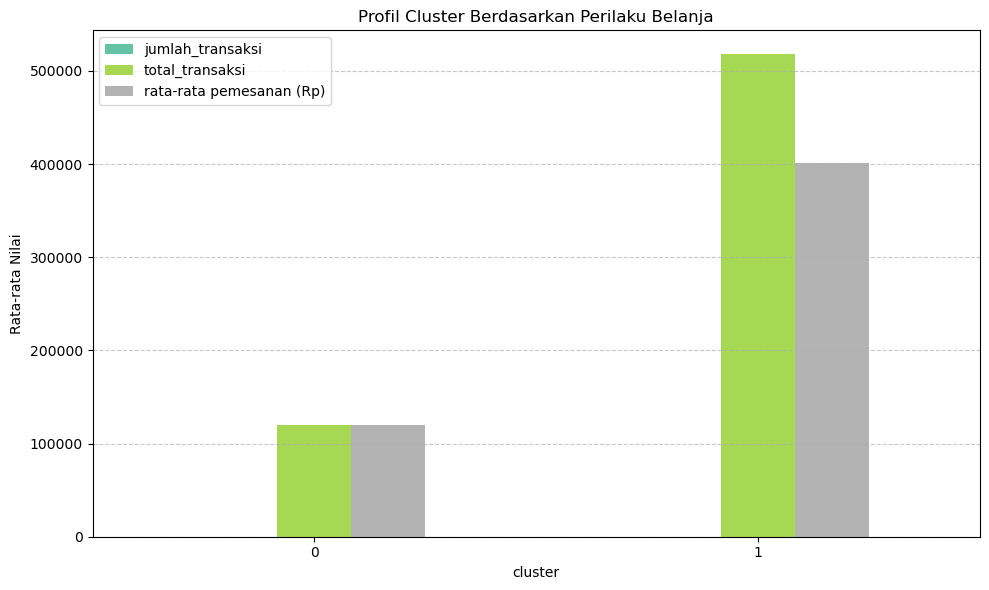

In [17]:
# Profil Cluster Berdasarkan Perilaku Belanja
# Visualisasi profil cluster
cluster_profile_plot = df_merge.groupby('cluster')[['jumlah_transaksi', 'total_transaksi', 'rata-rata pemesanan (Rp)']].mean()

cluster_profile_plot.plot(kind='bar', figsize=(10,6), colormap='Set2')
plt.title('Profil Cluster Berdasarkan Perilaku Belanja')
plt.ylabel('Rata-rata Nilai')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("assets/visualisasi3_cluster_profile.webp", format='webp')
plt.show()

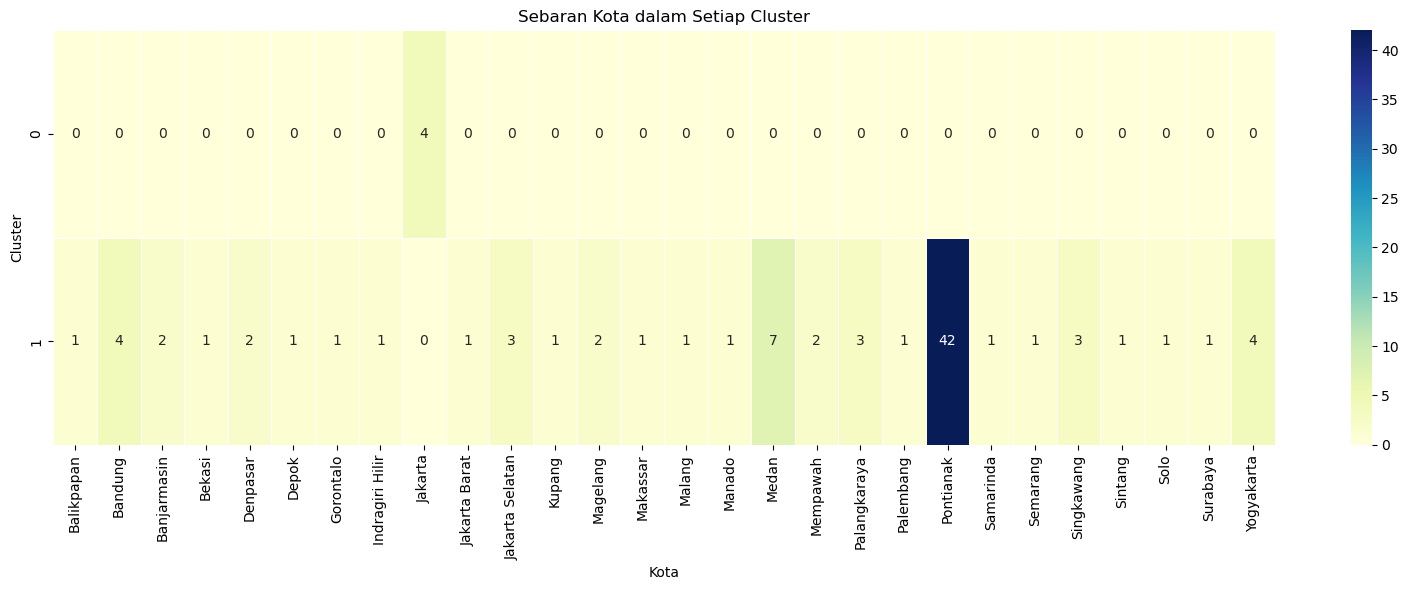

In [25]:
# Heatmap Distribusi Lokasi per Cluster
plt.figure(figsize=(16,6))
sns.heatmap(city_cluster, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=.5)
plt.title('Sebaran Kota dalam Setiap Cluster')
plt.xlabel('Kota')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig("assets/visualisasi4_heatmap_kota.webp", format='webp')
plt.show()

In [26]:
# Inisialisasi hasil
results = []

# Uji beberapa jumlah cluster 
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Lakukan KMeans dengan jumlah cluster berbeda
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Hitung Davies-Bouldin Index
    db_index = davies_bouldin_score(X_scaled, cluster_labels)
    
    # Simpan hasil
    results.append([n_clusters, db_index])

# Buat DataFrame hasil evaluasi
df_results = pd.DataFrame(results, columns=['Jumlah Cluster', 'Davies-Bouldin Index'])

# Tampilkan hasil evaluasi
display(df_results)

,Jumlah Cluster,Davies-Bouldin Index
0,2,1.065945
1,3,1.666016
2,4,1.498901


In [29]:
results_silhouette = []
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, cluster_labels)
    results_silhouette.append([n_clusters, sil_score])

# Tampilkan hasil sebagai DataFrame
df_silhouette = pd.DataFrame(
    results_silhouette,
    columns=['Jumlah Cluster', 'Silhouette Score']
)
display(df_silhouette)

,Jumlah Cluster,Silhouette Score
0,2,0.095576
1,3,0.202850
2,4,0.216927


In [28]:
# Menampilkan anggota dari masing-masing cluster
for cluster_num in sorted(df_merge['cluster'].unique()):
    print(f"\n📌 Anggota Cluster {cluster_num}:\n")
    display(
        df_merge[df_merge['cluster'] == cluster_num][[
            'customer_id', 'city', 'jumlah_transaksi', 'total_transaksi',
            'recency', 'rata-rata pemesanan (Rp)'
        ]].reset_index(drop=True)
    )


📌 Anggota Cluster 0:



,customer_id,city,jumlah_transaksi,total_transaksi,recency,rata-rata pemesanan (Rp)
0,21,Jakarta,1,20580,16,20580
1,95,Jakarta,1,31000,15,31000
2,96,Jakarta,1,269000,15,269000
3,97,Jakarta,1,160000,15,160000



📌 Anggota Cluster 1:



,customer_id,city,jumlah_transaksi,total_transaksi,recency,rata-rata pemesanan (Rp)
0,14,Pontianak,1,151900,16,151900
1,15,Depok,1,729019,15,729019
2,16,Medan,1,329000,16,329000
3,19,Pontianak,1,650400,15,650400
4,20,Singkawang,1,499000,16,499000
...,...,...,...,...,...,...
85,105,Kupang,3,3361500,15,1120500
86,106,Denpasar,2,1389999,15,695000
87,107,Palembang,2,707300,15,353650
88,108,Makassar,2,910704,15,455352
